# Calibrated microscopy in MEFL

Import Python modules.

In [1]:
import os
import sys
current_directory = os.getcwd()
# sys.path.append(os.path.join(current_directory, 'baseCode'))

import cytoflow as flow
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats
%matplotlib inline

# Read In Data

## Draw Morphology Gates

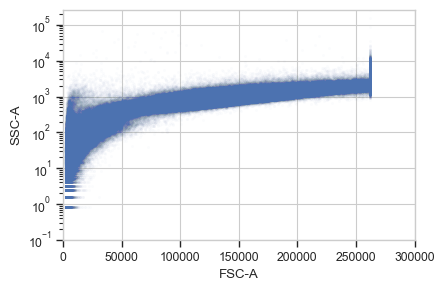

In [3]:
flow.ScatterplotView(xchannel = "FSC-A",
                     ychannel = "SSC-A",
                     yscale = "log").plot(ex, alpha = 0.01)
plt.xlim((0,300000))
plt.show()

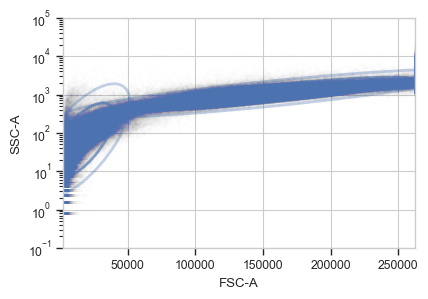

In [4]:
gm_1 = flow.GaussianMixtureOp(name = "Morpho1",
                                channels = ["FSC-A","SSC-A"],
                                scale = {"SSC-A" : "log"},
                                num_components = 2,
                                sigma = 4)
gm_1.estimate(ex)
gm_1.default_view().plot(ex, alpha = 0.005)
plt.ylim((0.1,100000));
ex_morpho1 = gm_1.apply(ex)
h = plt.gcf()
#h.savefig('Morpho1.png')
plt.show()

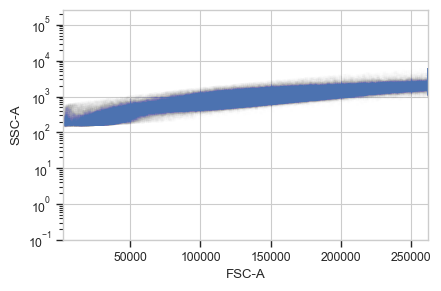

In [6]:
flow.ScatterplotView(xchannel = "FSC-A",
                     ychannel = "SSC-A",
                     yscale = "log",
                     subset = "Morpho1_2 == True").plot(ex_morpho1, alpha = 0.005)
h = plt.gcf()
#h.savefig('Morpho1Check.png')
plt.show()

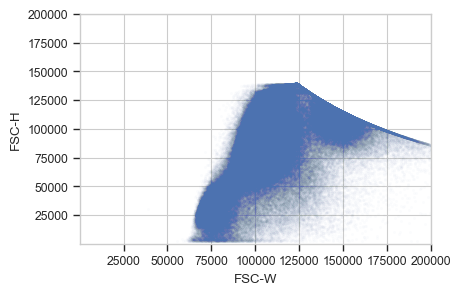

In [7]:
MorphoString = "Morpho1_2 == True"
flow.ScatterplotView(xchannel = "FSC-W",
                     ychannel = "FSC-H",
                     subset = MorphoString).plot(ex_morpho1, alpha = 0.01)
plt.ylim((0.1,200000));
plt.xlim((0.1,200000));
plt.show()

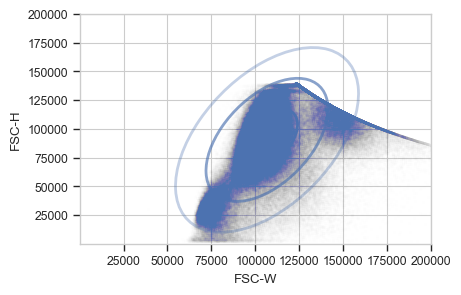

In [8]:
gm_1 = flow.GaussianMixtureOp(name = "Morpho2",
                                channels = ["FSC-W","FSC-H"],
                                num_components = 1,
                                sigma = 1)
gm_1.estimate(ex_morpho1,subset = MorphoString)
gm_1.default_view(subset = MorphoString).plot(ex_morpho1, alpha = 0.005)
plt.ylim((0.1,200000))
plt.xlim((0.1,200000))
ex_morpho2 = gm_1.apply(ex_morpho1)
plt.show()

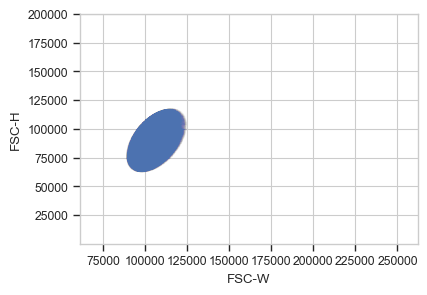

In [9]:
MorphoString = "Morpho1_2 == True and Morpho2_1 == True"
flow.ScatterplotView(xchannel = "FSC-W",
                     ychannel = "FSC-H",
                     subset = MorphoString).plot(ex_morpho2, alpha = 0.005)
plt.ylim((0.1,200000));
h = plt.gcf()
#h.savefig(ExperimentIndex+'Morpho2Check.png')

## clean up autofluorescence

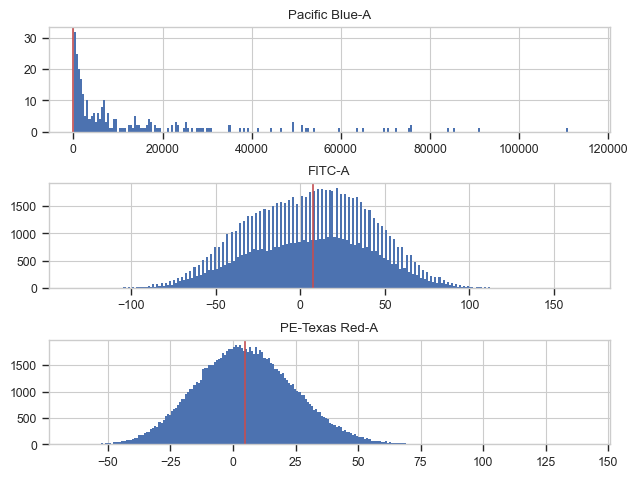

In [10]:

af_op = flow.AutofluorescenceOp()
af_op.blank_file = BlankControlName
af_op.channels = ["Pacific Blue-A", "FITC-A","PE-Texas Red-A"]

ex = ex_morpho2
af_op.estimate(ex, subset=MorphoString)
af_op.default_view().plot(ex)
plt.rcParams["figure.figsize"] = [10,10]
ex_af = af_op.apply(ex)

## Bleedthrough

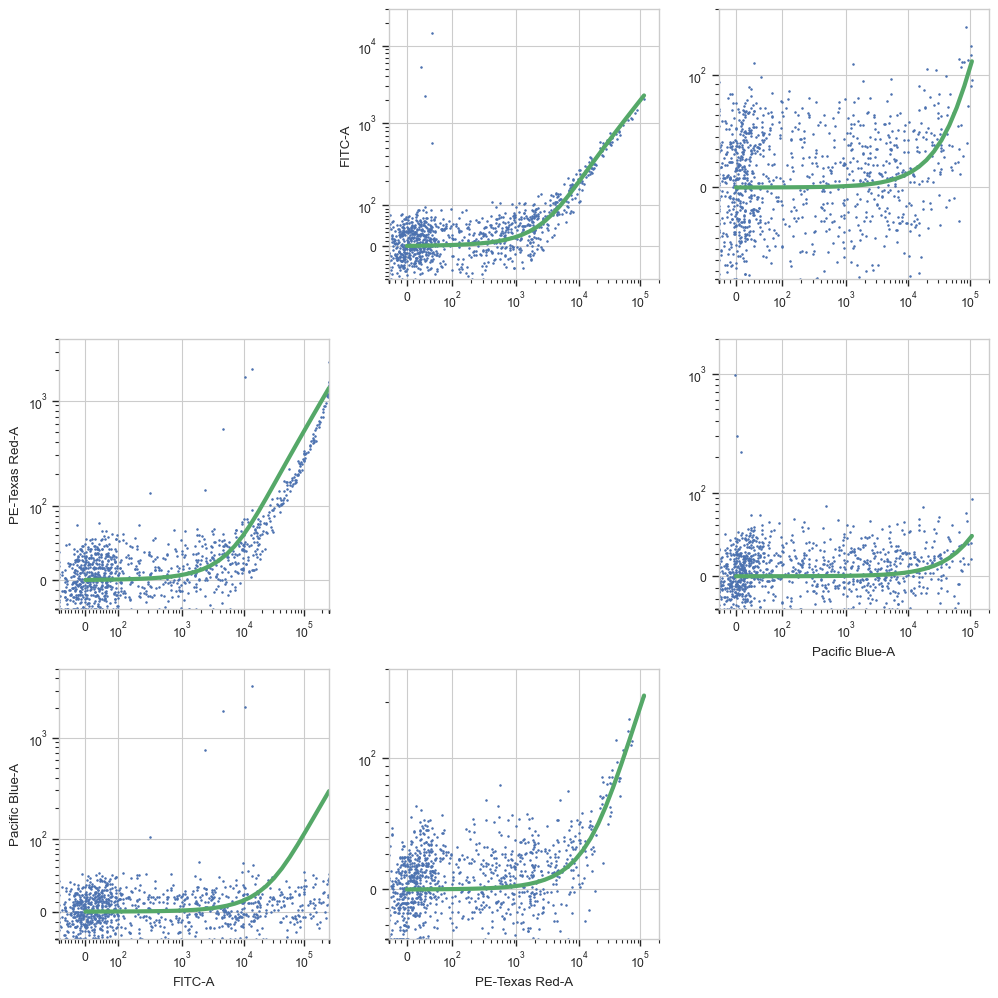

In [11]:
bl_op = flow.BleedthroughLinearOp()
bl_op.controls = {'Pacific Blue-A' : BlueControlName,
                  'FITC-A' : GreenControlName,
                  'PE-Texas Red-A' : RedControlName}
bl_op.estimate(ex, subset = MorphoString )
bl_op.default_view().plot(ex)

# Experiment 2 (09/24/2023) with different lysates/co-culture conditions

In [165]:
root = current_directory + "/expt09242023/"
RedChannel   = "mCherry-A"
GreenChannel = "EGFP-A"

samples = ['WT', 'EGFP', 'mCherry', 'MEGF10_IgG', 'MEGF10_FT', 'Fcgamma_IgG', 'Fcgamma_FT']
files, inputs = dict(), dict()
for sample in samples:
    files[sample] = root + f'{sample}.fcs'
    inputs[(sample, 1, sample)] = files[sample] # (sampleKey, repKey, sampleNameKey)

tubes = []

for (sampleKey, repKey, sampleNameKey), filename in inputs.items():
    tube = flow.Tube(file = filename,
                     conditions = {'SampleType' : sampleKey,
                                   'Rep'    : repKey,
                                   'SampleName': sampleNameKey})
    tubes.append(tube)

import_op = flow.ImportOp(conditions = {'SampleType' : "category",
                                        'Rep'  : "int",
                                        'SampleName': "category"},
                          tubes = tubes)
ex = import_op.apply()
# Get number of events per sample
events_per_sample = ex.data.groupby('SampleName').size()
print("\nNumber of events per sample:")
print(events_per_sample)


# can do ex.query('SampleType == "WT"') for example


Number of events per sample:
SampleName
EGFP            30000
Fcgamma_FT     100000
Fcgamma_IgG    100000
MEGF10_FT      100000
MEGF10_IgG      97605
WT              30000
mCherry         30000
dtype: int64


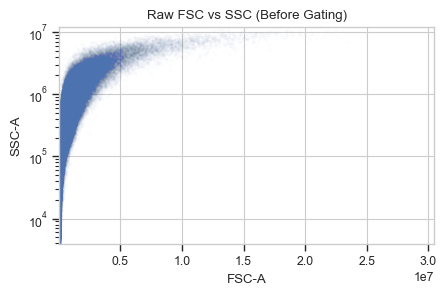

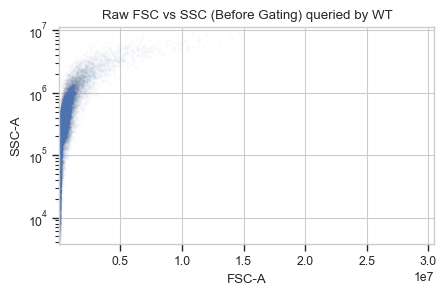

In [166]:
# First, let's look at the raw scatter plots for all samples before gating
scatter_view_raw = flow.ScatterplotView(
    xchannel='FSC-A',
    ychannel='SSC-A')
    # huefacet='SampleName')
scatter_view_raw.plot(ex, alpha=0.01)
plt.title('Raw FSC vs SSC (Before Gating)')
plt.yscale('log')
plt.show()

# First, let's look at the raw scatter plots for all samples before gating
scatter_view_raw = flow.ScatterplotView(
    xchannel='FSC-A',
    ychannel='SSC-A')
    # huefacet='SampleName')
scatter_view_raw.plot(ex.query('SampleType == "WT"'), alpha=0.01)
plt.title('Raw FSC vs SSC (Before Gating) queried by WT')
plt.yscale('log')
plt.show()



/Users/katie/opt/anaconda3/envs/cytoflow/lib/python3.8/site-packages/cytoflow/operations/base_op_views.py:373: CytoflowViewWarning: Setting 'huefacet' to 'Size'


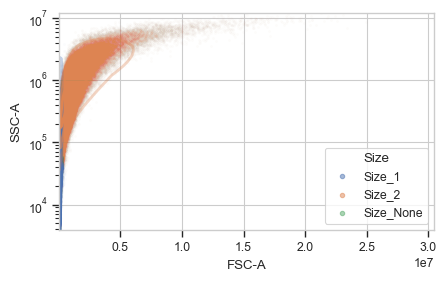

In [167]:
# Use GMMs to gate
GMMs = {}

GMMs['FSC and SSC'] = flow.GaussianMixtureOp(name = "Size",
                                channels = ["FSC-A","SSC-A"], 
                                scale = {"FSC-A": "log", "SSC-A" : "log"},
                                num_components = 2,   # by eyeballing the above plot
                                sigma = 2)
GMMs['FSC and SSC'].estimate(ex.query('SampleType == "WT"'))   # parameters associated with this instance 
gated_FSC_SSC = GMMs['FSC and SSC'].apply(ex)  

GMMs['FSC and SSC'].default_view().plot(gated_FSC_SSC, alpha=0.01)
plt.yscale('log')
plt.xscale('linear')



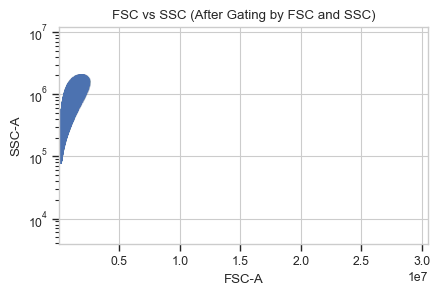

In [168]:
morpho_string_FSC_SSC = "Size_2 == True"
scatter_view_raw = flow.ScatterplotView(
    xchannel='FSC-A',
    ychannel='SSC-A',
    subset = morpho_string_FSC_SSC)
    # huefacet='SampleName')
scatter_view_raw.plot(gated_FSC_SSC, alpha=0.01)
plt.title('FSC vs SSC (After Gating by FSC and SSC)')
plt.yscale('log')
plt.show()

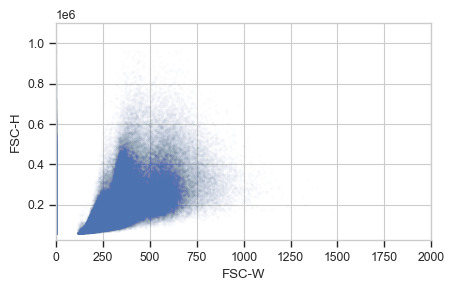

In [169]:
flow.ScatterplotView(xchannel = "FSC-W",
                     ychannel = "FSC-H",
                     subset = morpho_string_FSC_SSC).plot(gated_FSC_SSC, alpha = 0.01)
plt.ylim((25000,1100000));
plt.xlim((0,2000));
plt.show()

/Users/katie/opt/anaconda3/envs/cytoflow/lib/python3.8/site-packages/cytoflow/operations/base_op_views.py:373: CytoflowViewWarning: Setting 'huefacet' to 'HW'


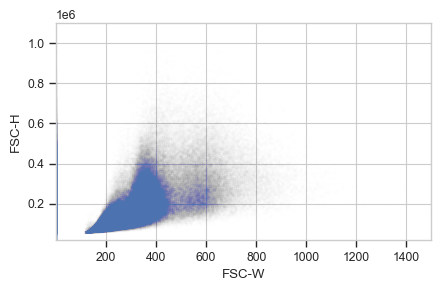

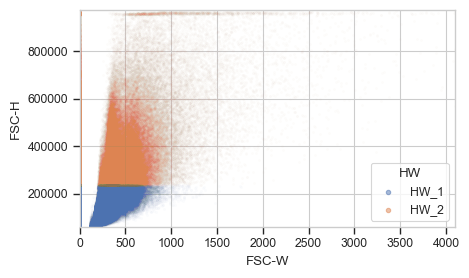

In [170]:
GMMs['height and width'] = flow.GaussianMixtureOp(name = "HW",
                                channels = ["FSC-W","FSC-H"],
                                num_components = 2,
                                sigma = 1)
GMMs['height and width'].estimate(gated_FSC_SSC.query('SampleType == "WT"'),subset = morpho_string_FSC_SSC)
GMMs['height and width'].default_view(subset = morpho_string_FSC_SSC).plot(gated_FSC_SSC, alpha = 0.005)
plt.ylim((20000,1100000));
plt.xlim((0.1,1500));
gated_height_width = GMMs['height and width'].apply(gated_FSC_SSC)
GMMs['height and width'].default_view().plot(gated_height_width, alpha=0.01)
plt.yscale('linear')
plt.xscale('linear')

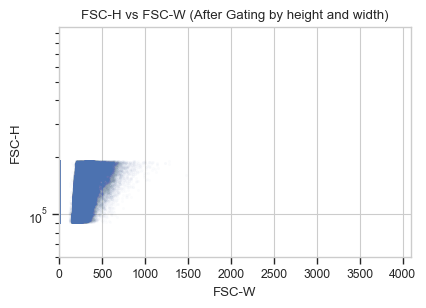

In [171]:
morpho_string_height_width = "HW_1 == True"
scatter_view_raw = flow.ScatterplotView(
    xchannel='FSC-W',
    ychannel='FSC-H',
    subset = morpho_string_height_width)
    # huefacet='SampleName')
scatter_view_raw.plot(gated_height_width, alpha=0.01)
plt.title('FSC-H vs FSC-W (After Gating by height and width)')
plt.yscale('log')
plt.show()

In [172]:
# Get number of events per sample to confirm we haven't totally lost any sample types
events_per_sample = gated_height_width.data[gated_height_width.data.HW_1 == True].groupby('SampleName').size()
print("\nNumber of events per sample:")
print(events_per_sample)

MorphoString = 'Size_2 == True and HW_1 == True'



Number of events per sample:
SampleName
EGFP           13509
Fcgamma_FT     37333
Fcgamma_IgG    38738
MEGF10_FT      36503
MEGF10_IgG     42946
WT             12910
mCherry        12740
dtype: int64


## Autofluorescence and bleedthrough

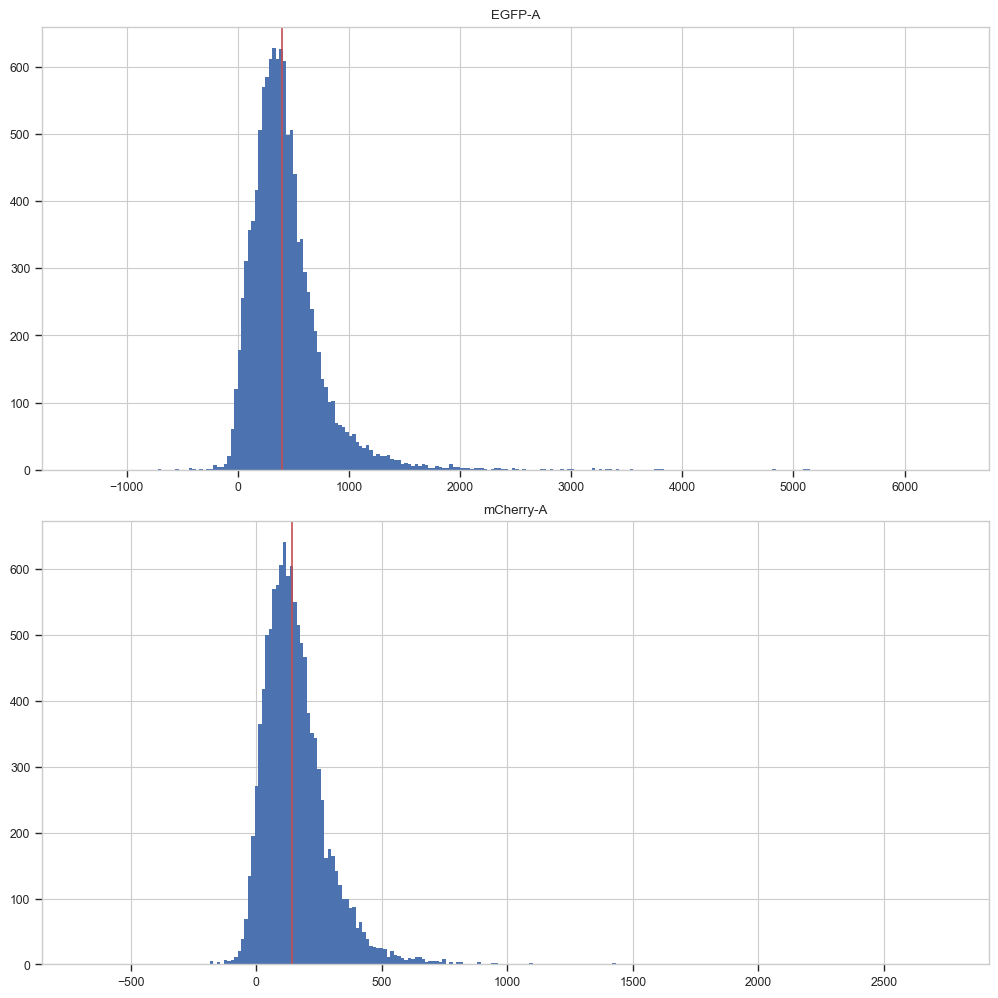

In [177]:
af_op = flow.AutofluorescenceOp()
af_op.blank_file = files['WT']
af_op.channels = [GreenChannel, RedChannel]

ex = gated_height_width
af_op.estimate(ex, subset=MorphoString)
af_op.default_view().plot(ex)
plt.rcParams["figure.figsize"] = [10,10]
ex_af = af_op.apply(ex)

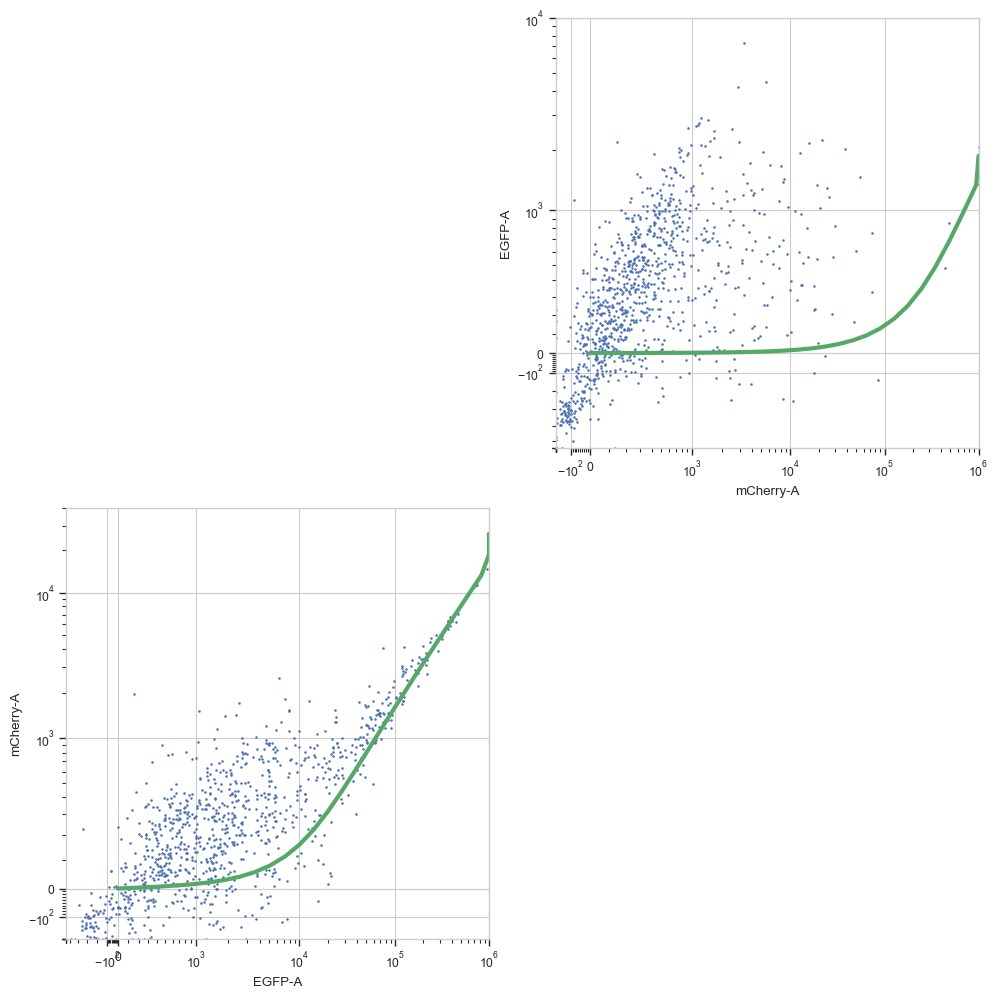

In [180]:
bl_op = flow.BleedthroughLinearOp()
bl_op.controls = {'EGFP-A' : files['EGFP'],
                  'mCherry-A' : files['mCherry']}
bl_op.estimate(ex_af, subset = MorphoString )
bl_op.default_view().plot(ex_af)
ex_bl = bl_op.apply(ex_af)

## Color gating

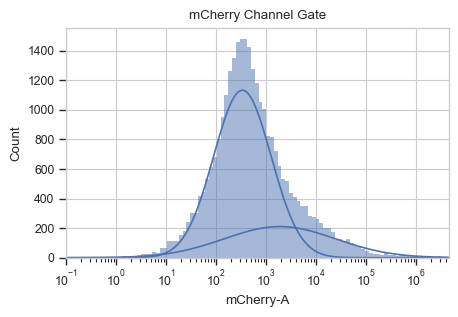

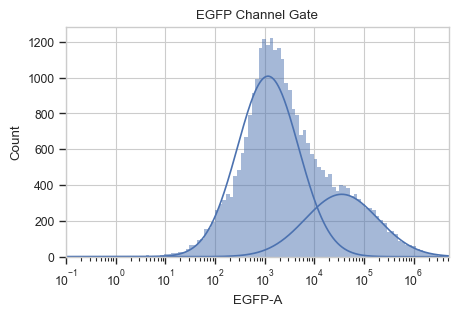

In [184]:
# Red Channel
GMMs['red'] = flow.GaussianMixtureOp(name="RedGate",
                               channels=[RedChannel], 
                               scale={RedChannel: "log"},
                               num_components=2,  # Assuming positive and negative populations (fluorescent red vs untransfected)
                               sigma=4)

# Estimate parameters of GMM using the red control sample
red_control = flow.ImportOp(tubes=[flow.Tube(file=files['mCherry'])]).apply()
GMMs['red'].estimate(red_control)

# Visualize the gate
GMMs['red'].default_view().plot(red_control)
plt.title("mCherry Channel Gate")
plt.show()

# Green Channel
GMMs['green'] = flow.GaussianMixtureOp(name="GreenGate",
                               channels=[GreenChannel], 
                               scale={GreenChannel: "log"},
                               num_components=2,  # Assuming positive and negative populations (fluorescent red vs untransfected)
                               sigma=4)

# Estimate parameters of GMM using the red control sample
green_control = flow.ImportOp(tubes=[flow.Tube(file=files['EGFP'])]).apply()
GMMs['green'].estimate(green_control)

# Visualize the gate
GMMs['green'].default_view().plot(green_control)
plt.title("EGFP Channel Gate")
plt.show()

In [185]:
# Apply red gate
gated_red = GMMs['red'].apply(ex_bl)

# Apply green gate
gated_green = GMMs['green'].apply(ex_bl)

# Apply both
gated = GMMs['green'].apply(gated_red)

## Plot results

In [186]:
gated.data.query('SampleName == "WT"')  # idt it means anything to analyze the color gating on WT, given that we're doing negative gating?

,APC-A,FSC-A,FSC-H,FSC-W,PE-A,PE-Cy7-A,PerCP-Cy5.5-A,Rep,SSC-A,SampleName,...,HW_1,HW_2,EGFP-A,mCherry-A,RedGate,RedGate_1,RedGate_2,GreenGate,GreenGate_1,GreenGate_2
0,114.960548,8.640915e+04,86918.718750,0.0,29.521681,-1.105957,-48.219727,1,1.304100e+04,WT,...,False,False,-338.181683,-118.947656,RedGate_None,False,False,GreenGate_None,False,False
1,256.980194,2.060100e+05,109355.679688,0.0,124.383301,0.840527,44.031837,1,1.627708e+05,WT,...,True,False,-166.648706,-29.235503,RedGate_None,False,False,GreenGate_None,False,False
2,165.215240,1.300769e+05,112179.203125,0.0,460.874420,56.742970,201.343170,1,1.021843e+05,WT,...,True,False,174.469445,35.923001,RedGate_1,True,True,GreenGate_1,True,True
3,534.309998,3.551661e+05,221289.593750,0.0,1229.426147,100.479889,466.935059,1,7.588977e+04,WT,...,False,True,1475.071121,426.194879,RedGate_1,True,True,GreenGate_1,True,True
4,29.816603,8.956434e+04,74197.757812,0.0,58.571487,16.869532,49.104492,1,3.538727e+04,WT,...,False,False,-308.111258,-131.653528,RedGate_None,False,False,GreenGate_None,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,48.204983,3.668504e+05,152933.765625,0.0,270.531830,-19.833496,163.548935,1,3.091226e+05,WT,...,True,False,-31.661737,74.628080,RedGate_1,True,True,GreenGate_None,False,False
29996,576.645996,6.347174e+05,276239.031250,0.0,855.745361,42.468750,281.768372,1,5.838565e+05,WT,...,False,True,635.235758,406.017669,RedGate_1,True,True,GreenGate_1,True,True
29997,679.957153,1.200802e+06,266604.812500,0.0,791.393372,-185.314163,579.123352,1,1.404145e+06,WT,...,False,True,1384.756248,349.324151,RedGate_1,True,True,GreenGate_1,True,True
29998,55.327347,9.083070e+04,62606.878906,0.0,22.885939,44.149807,-31.232227,1,2.525485e+04,WT,...,False,False,-319.787094,-123.356272,RedGate_None,False,False,GreenGate_None,False,False


In [188]:
all_EGFP = gated.data.query(MorphoString + ' and SampleName == "EGFP"')
all_mCherry = gated.data.query(MorphoString + ' and SampleName == "mCherry"')
print(len(all_EGFP))  # number of EGFP samples after morpho gating
print(len(gated.data.query(MorphoString + ' and SampleName == "EGFP" and RedGate_2 == False')))  # ^ subsetted to RedGate == False (want this number HIGH)

print(len(all_mCherry))  # number of mCherry samples after morpho gating
print(len(gated.data.query(MorphoString + ' and SampleName == "mCherry" and GreenGate_2 == False')))  # ^ subsetted to GreenGate == False (want this number HIGH)

11802
2783
10230
2655


In [191]:
gated.data.query(MorphoString + ' and SampleName == "Fcgamma_FT" and RedGate_2 == True and GreenGate_2 == True')

,APC-A,FSC-A,FSC-H,FSC-W,PE-A,PE-Cy7-A,PerCP-Cy5.5-A,Rep,SSC-A,SampleName,...,HW_1,HW_2,EGFP-A,mCherry-A,RedGate,RedGate_1,RedGate_2,GreenGate,GreenGate_1,GreenGate_2
387605,637.930786,460517.125000,138664.953125,443.0,739.546143,30.686623,243.974121,1,603437.000000,Fcgamma_FT,...,True,False,1694.278905,232.564485,RedGate_1,True,True,GreenGate_1,True,True
387607,92.693947,290385.562500,102700.640625,321.0,468.070526,-133.393173,185.004501,1,493759.812500,Fcgamma_FT,...,True,False,6931.409575,130.385606,RedGate_1,True,True,GreenGate_1,True,True
387613,277.698456,341667.937500,117673.921875,335.0,405.207916,13.079785,84.745804,1,373099.281250,Fcgamma_FT,...,True,False,1064.185908,70.062576,RedGate_1,True,True,GreenGate_1,True,True
387622,627.638000,419836.812500,135194.078125,386.0,736.965576,57.273830,228.918365,1,627878.750000,Fcgamma_FT,...,True,False,749.300930,560.190703,RedGate_1,True,True,GreenGate_1,True,True
387623,266.049042,416778.156250,179846.234375,318.0,387.527344,-6.090137,216.369446,1,209716.765625,Fcgamma_FT,...,True,True,245.380789,79.689725,RedGate_1,True,True,GreenGate_1,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487588,568.152283,747861.875000,172326.562500,525.0,929.284119,51.065723,301.882050,1,775900.437500,Fcgamma_FT,...,True,True,715.445986,673.923624,RedGate_1,True,True,GreenGate_1,True,True
487589,423.537323,182756.656250,111380.640625,224.0,558.523071,29.005568,194.220810,1,368533.031250,Fcgamma_FT,...,True,False,795.217344,426.033016,RedGate_1,True,True,GreenGate_1,True,True
487594,168.592087,227040.046875,105042.562500,256.0,312.027344,60.680176,128.541702,1,264597.531250,Fcgamma_FT,...,True,False,270.599295,77.781928,RedGate_1,True,True,GreenGate_1,True,True
487598,790.892029,330692.500000,94744.164062,371.0,783.813904,95.127052,587.307434,1,483670.406250,Fcgamma_FT,...,True,False,969.400723,968.968119,RedGate_1,True,True,GreenGate_1,True,True


In [190]:
gated.data.query(MorphoString + ' and SampleName == "Fcgamma_FT"')

,APC-A,FSC-A,FSC-H,FSC-W,PE-A,PE-Cy7-A,PerCP-Cy5.5-A,Rep,SSC-A,SampleName,...,HW_1,HW_2,EGFP-A,mCherry-A,RedGate,RedGate_1,RedGate_2,GreenGate,GreenGate_1,GreenGate_2
387605,637.930786,460517.125000,138664.953125,443.0,739.546143,30.686623,243.974121,1,603437.000000,Fcgamma_FT,...,True,False,1694.278905,232.564485,RedGate_1,True,True,GreenGate_1,True,True
387607,92.693947,290385.562500,102700.640625,321.0,468.070526,-133.393173,185.004501,1,493759.812500,Fcgamma_FT,...,True,False,6931.409575,130.385606,RedGate_1,True,True,GreenGate_1,True,True
387613,277.698456,341667.937500,117673.921875,335.0,405.207916,13.079785,84.745804,1,373099.281250,Fcgamma_FT,...,True,False,1064.185908,70.062576,RedGate_1,True,True,GreenGate_1,True,True
387622,627.638000,419836.812500,135194.078125,386.0,736.965576,57.273830,228.918365,1,627878.750000,Fcgamma_FT,...,True,False,749.300930,560.190703,RedGate_1,True,True,GreenGate_1,True,True
387623,266.049042,416778.156250,179846.234375,318.0,387.527344,-6.090137,216.369446,1,209716.765625,Fcgamma_FT,...,True,True,245.380789,79.689725,RedGate_1,True,True,GreenGate_1,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487589,423.537323,182756.656250,111380.640625,224.0,558.523071,29.005568,194.220810,1,368533.031250,Fcgamma_FT,...,True,False,795.217344,426.033016,RedGate_1,True,True,GreenGate_1,True,True
487594,168.592087,227040.046875,105042.562500,256.0,312.027344,60.680176,128.541702,1,264597.531250,Fcgamma_FT,...,True,False,270.599295,77.781928,RedGate_1,True,True,GreenGate_1,True,True
487598,790.892029,330692.500000,94744.164062,371.0,783.813904,95.127052,587.307434,1,483670.406250,Fcgamma_FT,...,True,False,969.400723,968.968119,RedGate_1,True,True,GreenGate_1,True,True
487599,233.637115,332479.531250,175814.234375,274.0,374.757233,2.521582,175.567001,1,148821.250000,Fcgamma_FT,...,True,True,29.260455,17.956853,RedGate_1,True,True,GreenGate_1,True,False
